In [466]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [467]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Forwarder-Sequencer Latency

In [477]:
PREFIX = 'main/ycsb-asymmetry/ddr_ts-clients3000-80'
SERVER = '0-0'

forw_sequ_latency_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("src_time", T.LongType(), False),
    StructField("dst_time", T.LongType(), False),
    StructField("src_recv_time", T.LongType(), False),
    StructField("avg_time", T.LongType(), False)
])

fs_latency_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/forw_sequ_latency.csv",
    header=True,
    schema=forw_sequ_latency_schema
).toPandas()
fs_latency_df.index = normalize2(fs_latency_df["src_time"])
fs_latency_df["latency"] = (fs_latency_df["dst_time"] - fs_latency_df["src_time"]) / 1000000
fs_latency_df["avg_time"] /= 1000000

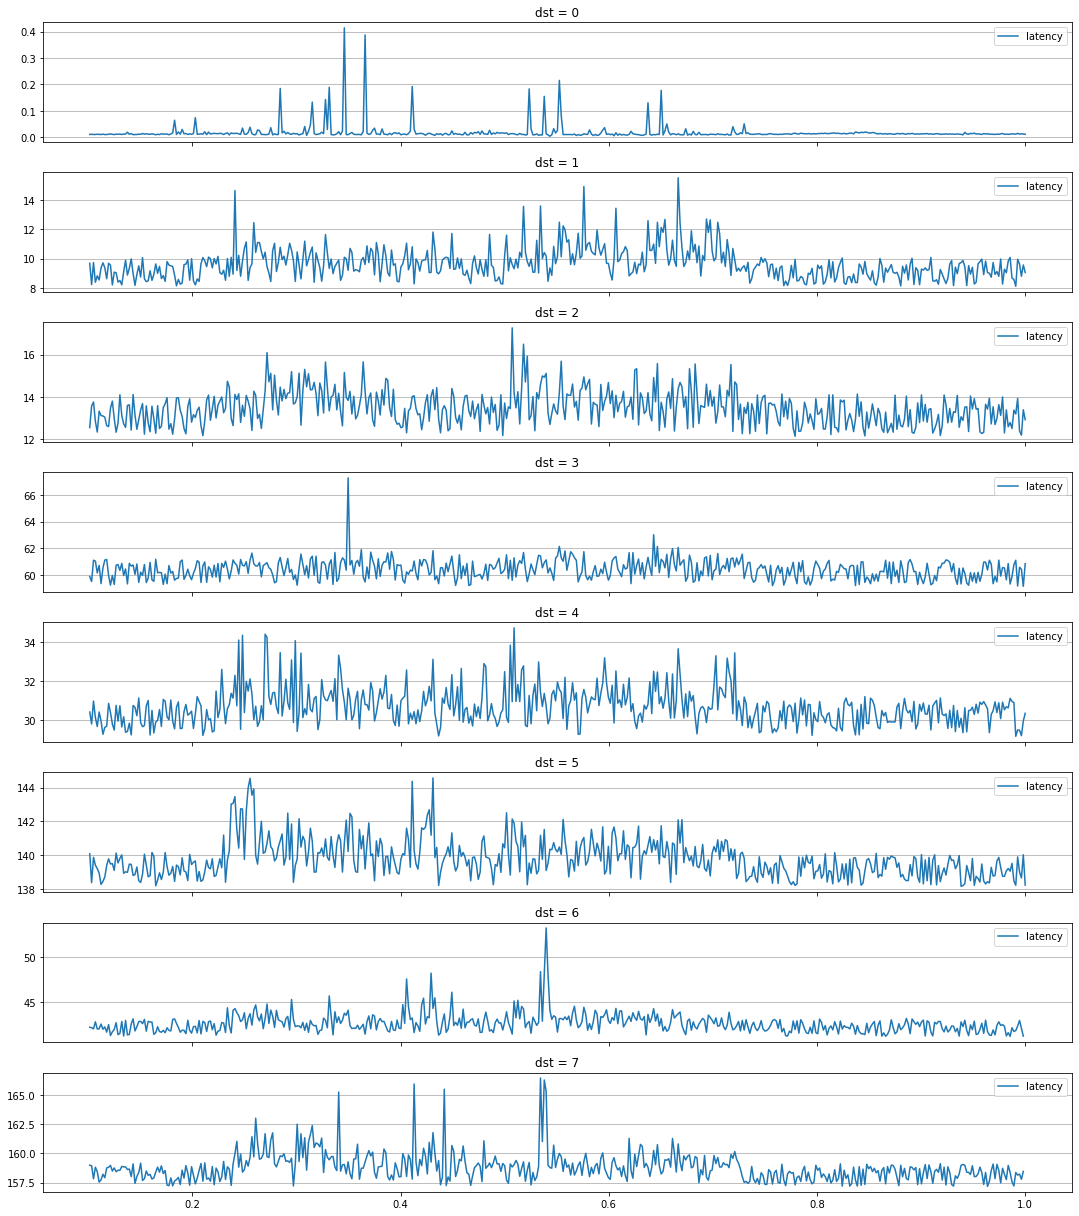

In [478]:
dst = sorted(fs_latency_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    fs_latency_df.loc[(fs_latency_df.dst == d) & (fs_latency_df.index > 0.1) & (fs_latency_df.latency < 300)].plot(
        y="latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")
    axes[i].grid(axis='y')

plt.tight_layout()

In [479]:
txn_timestamps_df = txn_timestamps_csv(spark, PREFIX).toPandas()
txn_timestamps_df[txn_timestamps_df.dev < 0]

,txn_id,from,txn_timestamp,server_time,dev,replica,partition
1392,97103,3,1632520070083324092,1632520070083356302,-0.032210,4,0
1404,86927,27,1632520070098072303,1632520070098204311,-0.132008,4,0
1407,87224,24,1632520070099071008,1632520070099748965,-0.677957,4,0
1461,91125,25,1632520070168274411,1632520070168657933,-0.383522,4,0
1843,76029,29,1632520070652866401,1632520070653482438,-0.616037,4,0
...,...,...,...,...,...,...,...
316626,2339210,10,1632520122354982675,1632520122355034181,-0.051506,3,1
316648,4630402,2,1632520122387811243,1632520122388594140,-0.782897,3,1
316983,8258016,16,1632520123018720356,1632520123019454714,-0.734358,3,1
317051,4713000,0,1632520123147108550,1632520123147405733,-0.297183,3,1


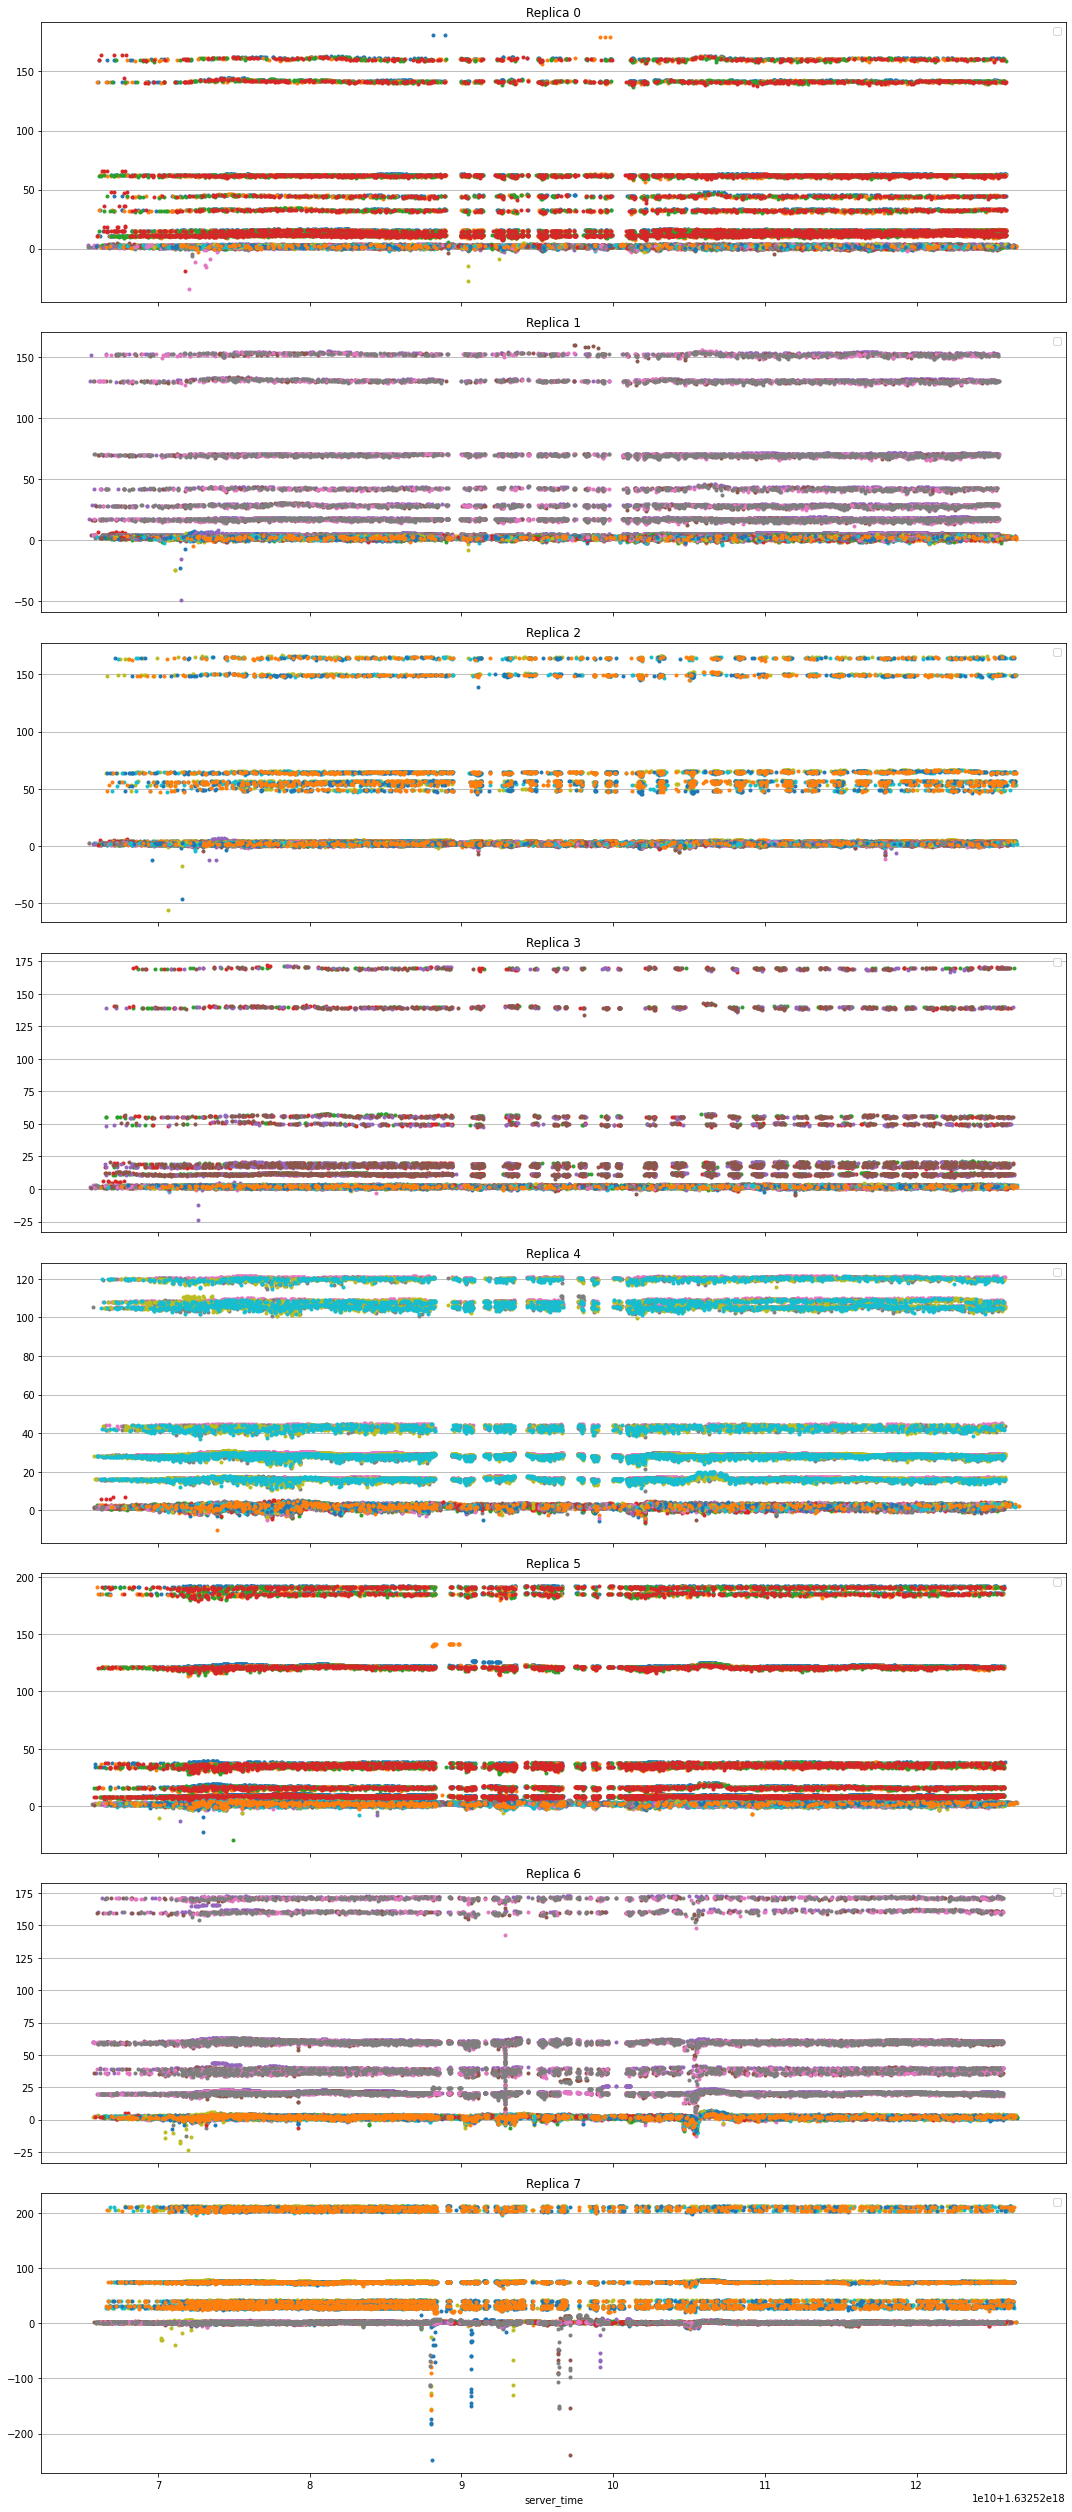

In [480]:
replicas = sorted(txn_timestamps_df["replica"].unique())

_, axes = plt.subplots(len(replicas), 1, figsize=(15, 35), sharex=True)

for i, r in enumerate(replicas):
    filtered_by_rep = txn_timestamps_df[txn_timestamps_df.replica == r]
    from_machines = sorted(filtered_by_rep["from"].unique())
    for f in from_machines:
        filtered_by_rep[filtered_by_rep["from"] == f].plot(
            x="server_time",
            y="dev",
            ax=axes[i],
            linewidth=0,
            marker='.',
            label=f"{f}",
        )
    axes[i].set_title(f"Replica {r}")
    axes[i].grid(axis='y')
    axes[i].legend([])
#     axes[i].set_yscale('log')

plt.tight_layout()

# Deadlocks

<AxesSubplot:xlabel='time'>

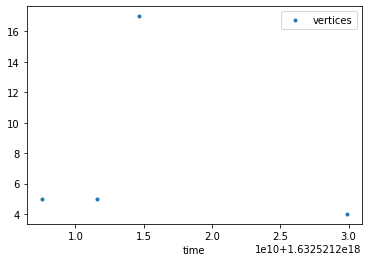

In [484]:
# deadlocks_df = deadlocks_csv(spark, 'main/ycsb/ddr_ts-hot100mp100mh100').where(col("replica") == 0).where(col("partition") == 0).toPandas()
deadlocks_df = deadlocks_csv(spark, 'main/ycsb-2/ddr_ts-hot100mp0mh25').where(col("replica") == 0).where(col("partition") == 0).toPandas()
deadlocks_df.plot(x="time", y="vertices", linewidth=0, marker='.')

# Clock Synchronization

In [132]:
PREFIX = 'main/ycsb/ddr_ts-hot100mp100mh100'
SERVER = '1-0'

clock_sync_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("src_send_time", T.DoubleType(), False),
    StructField("dst_send_time", T.DoubleType(), False),
    StructField("src_recv_time", T.DoubleType(), False),
    StructField("local_slog_time", T.DoubleType(), False),
    StructField("avg_latency", T.DoubleType(), False),
    StructField("new_offset", T.DoubleType(), False),
])

clock_sync_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/clock_sync.csv",
    header=True,
    schema=clock_sync_schema
).toPandas()
clock_sync_df.index = normalize2(clock_sync_df["src_recv_time"])
clock_sync_df.sort_index(inplace=True)
clock_sync_df.loc[:, "avg_latency"] = clock_sync_df["avg_latency"] / 1000000
clock_sync_df.loc[:, "new_offset"] = clock_sync_df["new_offset"] / 1000000

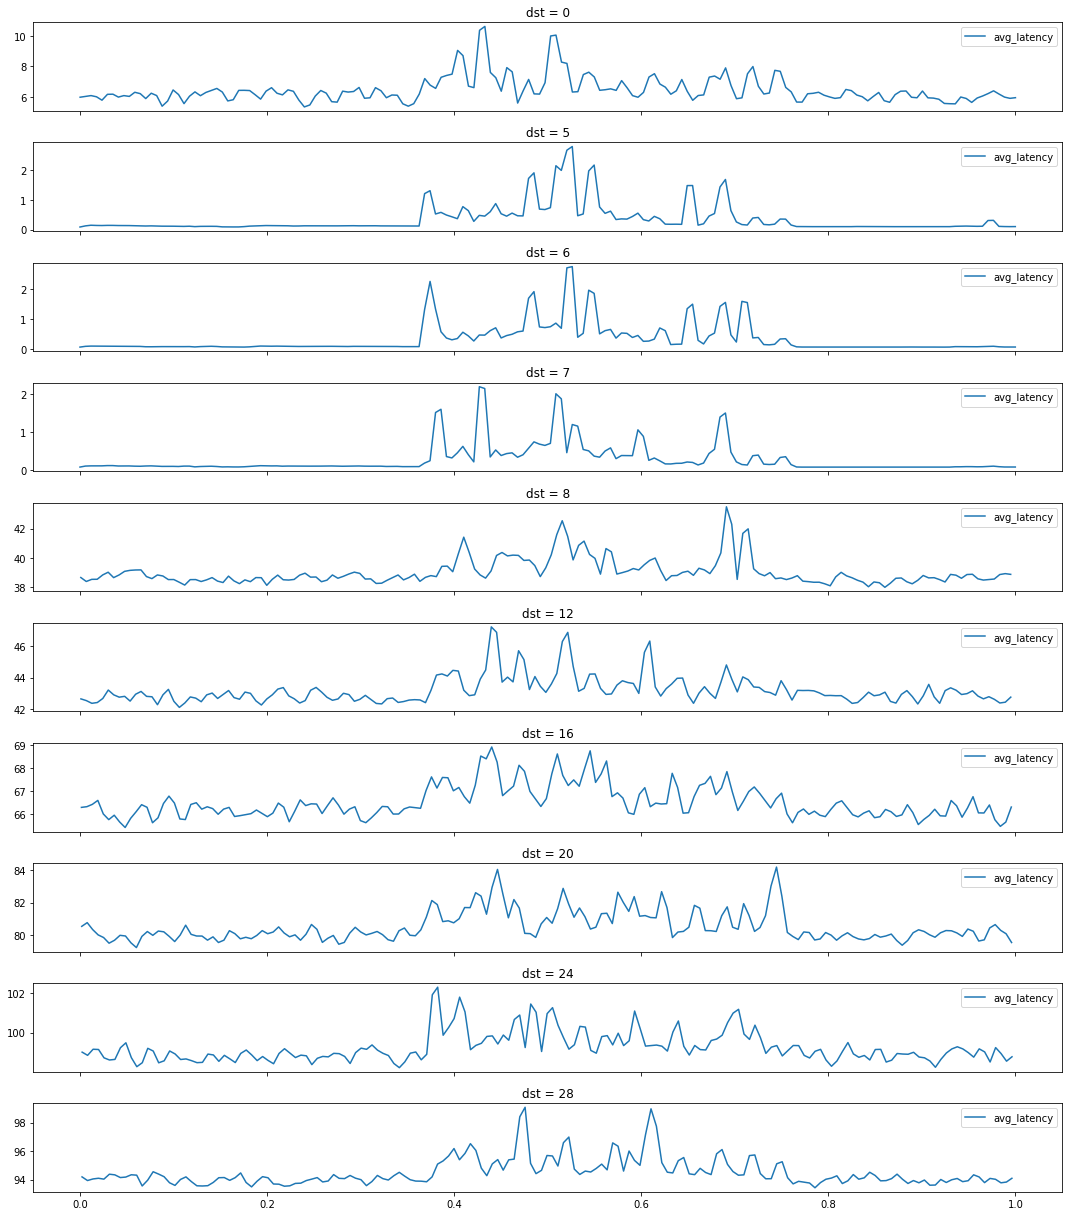

In [133]:
dst = sorted(clock_sync_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    clock_sync_df.loc[(clock_sync_df.dst == d)].plot(
        y="avg_latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")

plt.tight_layout()

<AxesSubplot:>

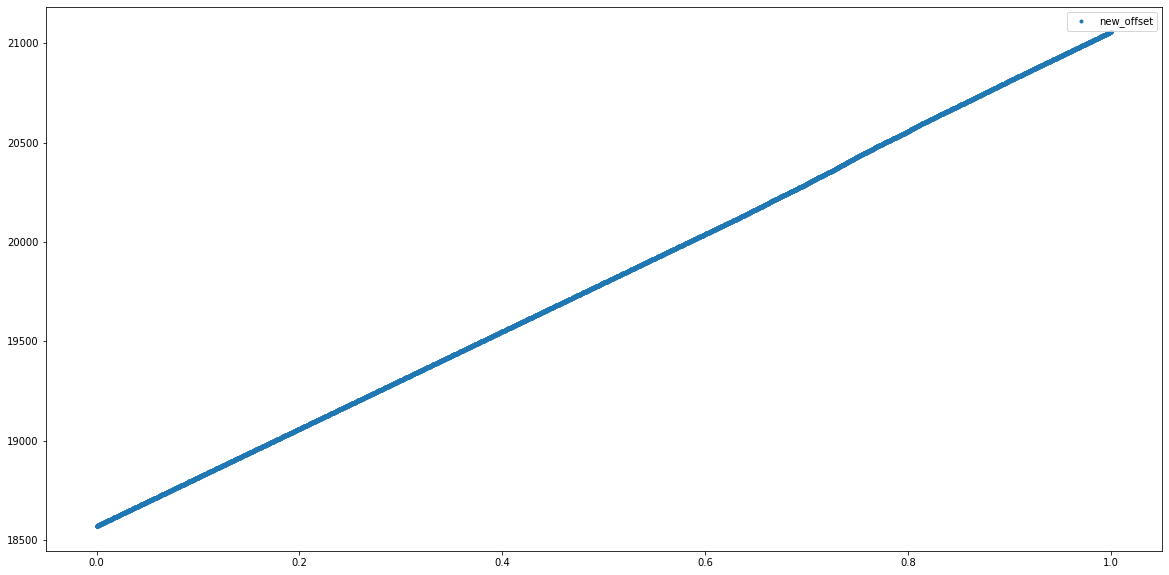

In [23]:
clock_sync_df.plot(y="new_offset", figsize=(20, 10), marker='.', linewidth=0)
    

# Global Log Position

In [3]:
PREFIX = 'main/ycsb/baseline-hot10000mp0mh75'

txn_sdf = transactions_csv(spark, PREFIX)\
    .select(
        "txn_id",
        "coordinator",
        "replicas",
        "partitions",
        "global_log_pos",
        "machine")

txn_df = txn_sdf.toPandas()
txn_df

,txn_id,coordinator,replicas,partitions,global_log_pos,machine
0,18128004,4,"[0, 1]",[0],"[1, 1935157, 0, 1935192]",1
1,20152504,4,"[0, 1]",[1],"[1, 2120399, 0, 2120623]",1
2,20740904,4,"[1, 2]",[3],"[1, 2185538, 2, 2186332]",1
3,18382104,4,"[0, 1]",[0],"[1, 1959008, 0, 1959038]",1
4,19055107,7,"[1, 2]",[0],"[1, 2022336, 2, 2023258]",1
...,...,...,...,...,...,...
199995,21931102,2,[0],[0],"[0, 2157733]",0
199996,21073901,1,"[0, 1]",[2],"[0, 2045421, 1, 2045690]",0
199997,19873203,3,"[0, 6]",[2],"[0, 1910492, 6, 1912741]",0
199998,21874001,1,"[0, 1]",[1],"[0, 2145115, 1, 2145326]",0


In [101]:
txn_df["machine"].unique()

array([1, 6, 3, 5, 4, 7, 2, 0], dtype=int32)

In [102]:
global_log = []
for row in txn_df.iterrows():
    txn_id = row[1]["txn_id"]
    global_log_pos = row[1]["global_log_pos"]
    region = row[1]["machine"]
    partition = row[1]["coordinator"] % 4
    for i in range(0, len(global_log_pos), 2):
        global_log.append((txn_id, region, partition, global_log_pos[i], global_log_pos[i+1]))
        
global_df = pd.DataFrame(global_log, columns=["txn_id", "region", "partition", "home", "pos"]).sort_values("pos").reset_index(drop=True)
global_df

,txn_id,region,partition,home,pos
0,19230610,2,2,2,1909451
1,20973230,7,2,7,1909452
2,19230511,2,3,2,1909453
3,19230711,2,3,2,1909454
4,22188623,5,3,5,1909455
...,...,...,...,...,...
349571,26053324,6,0,7,2219741
349572,26051927,6,3,7,2219742
349573,26053624,6,0,7,2219747
349574,19130016,4,0,7,2219748


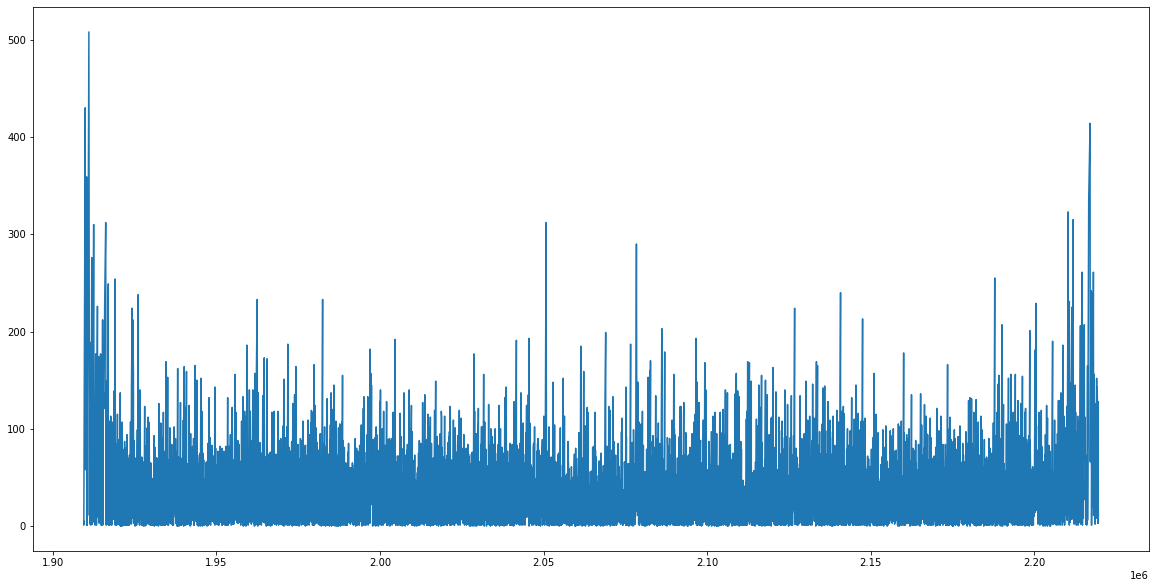

In [122]:
pos = np.array(global_df[(global_df["region"] == 7) & (global_df["partition"] == 3)]["pos"])
diff = pos[1:] - pos[:-1]
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(pos[1:], diff)

<AxesSubplot:xlabel='global_log_dist', ylabel='latency'>

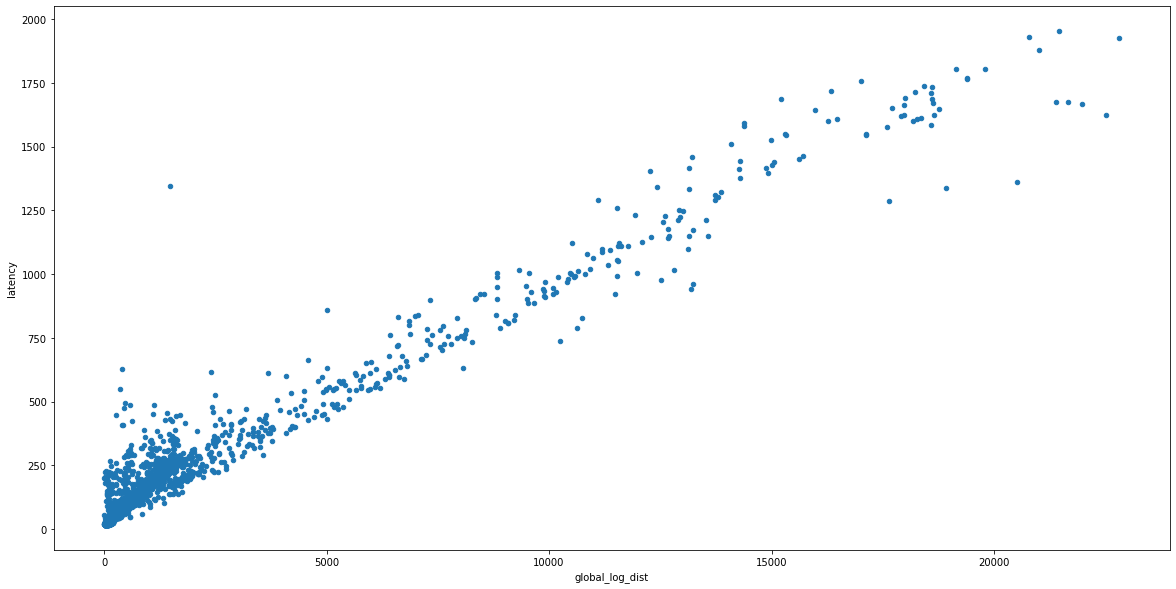

In [48]:
txn_df.plot.scatter(x="global_log_dist", y="latency", figsize=(20, 10))

In [397]:
PREFIX = 'main/ycsb-asymmetry-3/ddr_ts'
SERVER = '0-0'

global_log_schema = StructType([
    StructField("replica", T.IntegerType(), False),
    StructField("batch_id", T.DoubleType(), False),
    StructField("txn_id", T.DoubleType(), False),
    StructField("timestamp", T.DoubleType(), False),
    StructField("depart_from_coordinator", T.DoubleType(), False),
    StructField("arrive_at_home", T.DoubleType(), False),
    StructField("enter_local_batch", T.DoubleType(), False),
])

global_log_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/global_log.csv",
    header=True,
    schema=global_log_schema
).toPandas()
# clock_sync_df.index = normalize2(clock_sync_df["src_recv_time"])
# clock_sync_df.sort_index(inplace=True)
# clock_sync_df.loc[:, "avg_latency"] = clock_sync_df["avg_latency"] / 1000000
# clock_sync_df.loc[:, "new_offset"] = clock_sync_df["new_offset"] / 1000000
global_log_df["timestamp"] = global_log_df["timestamp"] / 1000000
global_log_df["depart_from_coordinator"] = normalize(global_log_df["depart_from_coordinator"]) / 1000000
global_log_df["arrive_at_home"] = global_log_df["arrive_at_home"] / 1000000
global_log_df["enter_local_batch"] = global_log_df["enter_local_batch"] / 1000000
global_log_df["machine"] = global_log_df["txn_id"] % 100
global_log_df["dev"] = global_log_df["timestamp"] - global_log_df["arrive_at_home"]
global_log_df["late"] = global_log_df["timestamp"] - global_log_df["enter_local_batch"]
global_log_df["ts"] = normalize(global_log_df["timestamp"])

In [398]:
global_log_df

,replica,batch_id,txn_id,timestamp,depart_from_coordinator,arrive_at_home,enter_local_batch,machine,dev,late,ts
0,2,108.0,208.0,1.632432e+12,0.000000,1.632432e+12,1.632432e+12,8.0,7.984863,-0.002441,0.000000
1,2,308.0,209.0,1.632432e+12,6.155008,1.632432e+12,1.632432e+12,9.0,39.917969,-0.012939,38.225830
2,2,308.0,308.0,1.632432e+12,12.477952,1.632432e+12,1.632432e+12,8.0,35.336914,-0.013428,39.821533
3,2,408.0,408.0,1.632432e+12,25.106432,1.632432e+12,1.632432e+12,8.0,35.337891,-0.021973,52.449707
4,2,508.0,610.0,1.632432e+12,62.423808,1.632432e+12,1.632432e+12,10.0,7.964111,-0.016357,62.444824
...,...,...,...,...,...,...,...,...,...,...,...
111762,6,479424.0,2186604.0,1.632432e+12,30430.410496,1.632432e+12,1.632432e+12,4.0,1.577393,-0.001709,30523.633301
111763,6,479524.0,1585902.0,1.632432e+12,30475.952896,1.632432e+12,1.632432e+12,2.0,1.466553,-0.000732,30576.285156
111764,6,479624.0,1586400.0,1.632432e+12,30485.116672,1.632432e+12,1.632432e+12,0.0,1.639648,-0.001709,30585.225342
111765,6,479624.0,1586403.0,1.632432e+12,30486.528768,1.632432e+12,1.632432e+12,3.0,2.951172,-0.017578,30586.864502


74566


<AxesSubplot:xlabel='ts'>

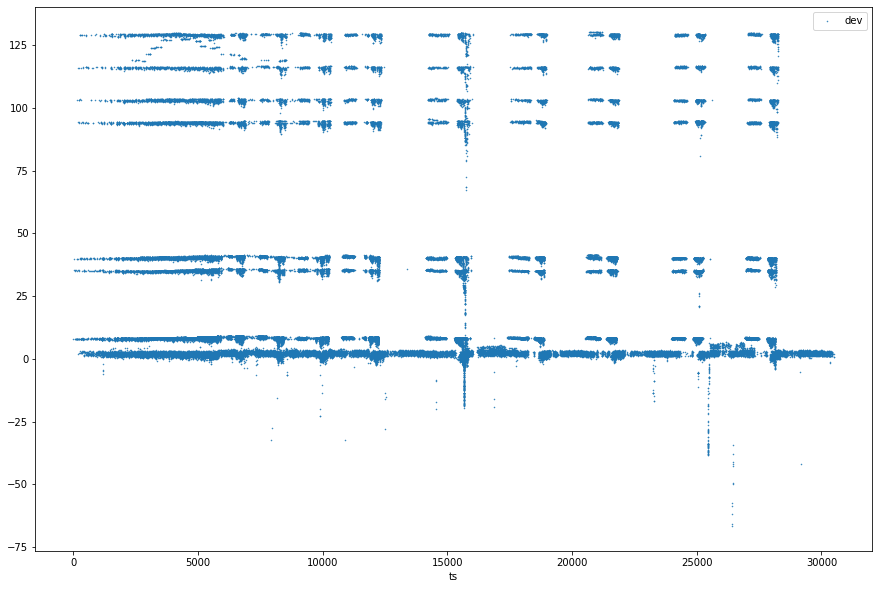

In [432]:
df = global_log_df[
    (global_log_df.replica == 2)
#     (global_log_df["timestamp"] > 15600) & 
#     (global_log_df["timestamp"] < 15800) &
#     (global_log_df["machine"] == 3)
].sort_values("ts")
print(len(df))
df.plot(x='ts', y='dev', figsize=(15, 10), linewidth=0.0, marker='.', markersize=1.0)


489
3175


<AxesSubplot:xlabel='ts'>

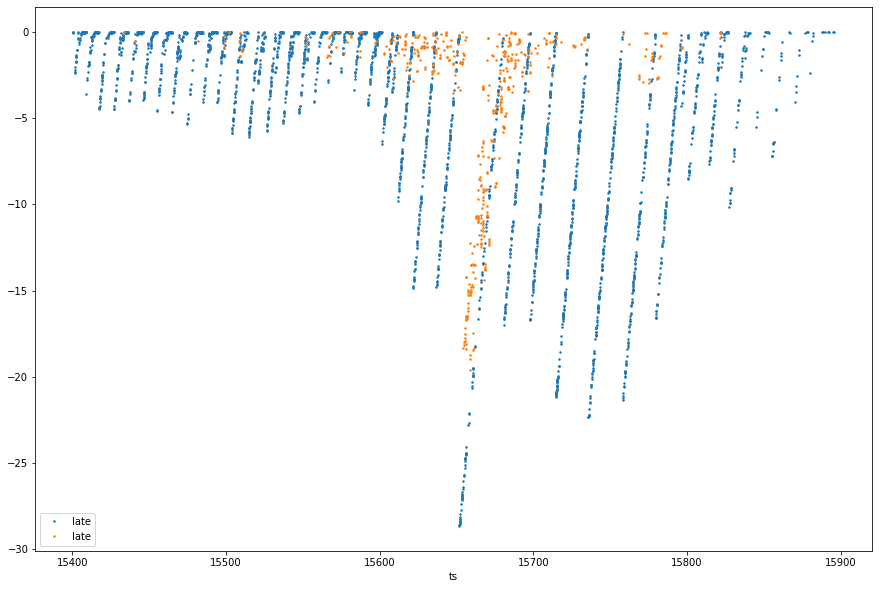

In [439]:
from_time = 15400
to_time = 15900

df = global_log_df[
    (global_log_df.replica == 2) &
    (global_log_df["ts"] > from_time) & 
    (global_log_df["ts"] < to_time)
].sort_values("ts")


df1 = global_log_df[
    (global_log_df.replica == 2) &
    (global_log_df["ts"] > from_time) & 
    (global_log_df["ts"] < to_time) &
#     (global_log_df["machine"] == 3)
    (global_log_df.dev <= 0)
].sort_values("ts")
print(len(df1))

df2 = global_log_df[
    (global_log_df.replica == 2) &
    (global_log_df["ts"] > from_time) & 
    (global_log_df["ts"] < to_time) &
#     (global_log_df["machine"] == 3)
    (global_log_df.dev > 0)
].sort_values("ts")
print(len(df2))

_, ax = plt.subplots(1, 1, figsize=(15, 10))
df2.plot(x='ts', y='late', ax=ax, linewidth=0.0, marker='.', markersize=3.0)
df1.plot(x='ts', y='late', ax=ax, linewidth=0.0, marker='.', markersize=3.0)


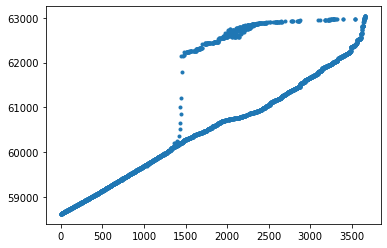

In [441]:
plt.plot(df.sort_values("ts").index, linewidth=0, marker='.')